# Predicting Blood Glucose levels for Type 1 Diabetes with Recurrent Neural Networks

The concentration of glucose in the blood fluctuates for everyone throughout the day in response to different stimuli, such as eating carbohydrates and exercise. This level is primarily maintained by insulin secreted by the pancreas. As glucose in the blood rises, the pancreas responds by increasing the concentration of insulin in step with this, and as such brings the blood glucose levels to within a homeostatic medium.

For a person with Type 1 Diabetes, the pancreas is not able perform this function and glucose levels have no means of self-regulation through the body's automatic secretion of insulin. As such, Type 1 Diabetics need to manually administer their insulin through insulin injections or electronic insulin pumps to keep their glucose concentration within a healthy interval. In order for a Type 1 Diabetic to administer the optimal level of insulin in response to their glucose levels, they take a reading of their blood glucose beforehand. They will then quantify the expected carbohydrates they intend to consume and then administer a specific insulin amount themselves. 

Within the last 10 years, a sizeable percentage of Type 1 Diabetics now use sensors that provide glucose readings in regular intervals. This can be used for taking glucose measurements automatically, and not having to rely on individual finger-prick tests each time. 




# 1.0 Recurrent Neural Networks

Recurrent Neural Networks (RNNs) are a class of neural networks that are particularly suited for sequential data processing, making them ideal for applications in time series forecasting. The key feature of RNNs is their ability to maintain a 'memory' of previous inputs by incorporating feedback loops in their architecture. This allows them to capture temporal dependencies and patterns in time series data, which is crucial for accurate forecasting.

Time series forecasting involves predicting future values of a sequence based on its past values. RNNs are well-suited for this task due to their ability to process sequences and maintain state across time steps. Blood glucose levels exhibit temporal patterns and dependencies, such as postprandial spikes (after eating) and circadian variations. RNNs are adept at capturing these patterns due to their sequential processing nature and memory of past inputs, making them suitable for modeling glucose dynamics. The use of Continuous Glucose Monitoring (CGM) systems generates a continuous stream of glucose data. RNNs are well-suited for real-time analysis of this data, providing timely predictions that can inform immediate management decisions.

Given the challenges of predicting blood glucose levels, advanced variants of RNNs, such as Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), can be employed. These architectures are designed to better handle long-term dependencies and avoid issues like the vanishing gradient problem, making them more effective for predicting complex time series data like blood glucose levels.

# 2.0 Data pre-processing and feature engineering

The dataset comprises of glucose readings from a dexcom G6 sensor in units of mmol/litre at 5 minute intervals over a 3 month period. The dataset is split into training, validation and test data amounting to 70%, 20% and 10% of the total data respectively. 

To pre-prosess the data, all readings above 40mmol/litre are removed in order to remove any outliers impacting training. Null values are also removed and replaced with the previous timestep's glucose value. 

It is important to scale features before training a neural network. The values of glucose readings vary mostly between 2 mmol/litre and 16mmol/litre. These values therefore don't exist in the values less than 1 which are beneficial to learning.  In order to help this, normalisation is a common way of doing this scaling: subtract the mean and divide by the standard deviation of the glucose values. This brings the distributions between 0 and 1 required for training effectively. The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets. 


Glucose readings may vary throughout the day for various reasons. One such reason might be periodical, for example perhaps levels are different while someone is asleep, the morning and the evening. One way to add this is to add a feature to the data that signals the time by vary sinusoidally throughout the day. This could look like:


                            df['Day sin'] = np.sin(timestamp * (2 * np.pi / day))

One way of testing if there is indeed a high periodicity to the dataset is to perform a Fast Fourier Transform (FFT) on the dataset. This will highlight any time frequencies within the data that have a high amplitude and therefore a strong periodicity present that is worth adding this feature for. This was investigated and the plot shown below.


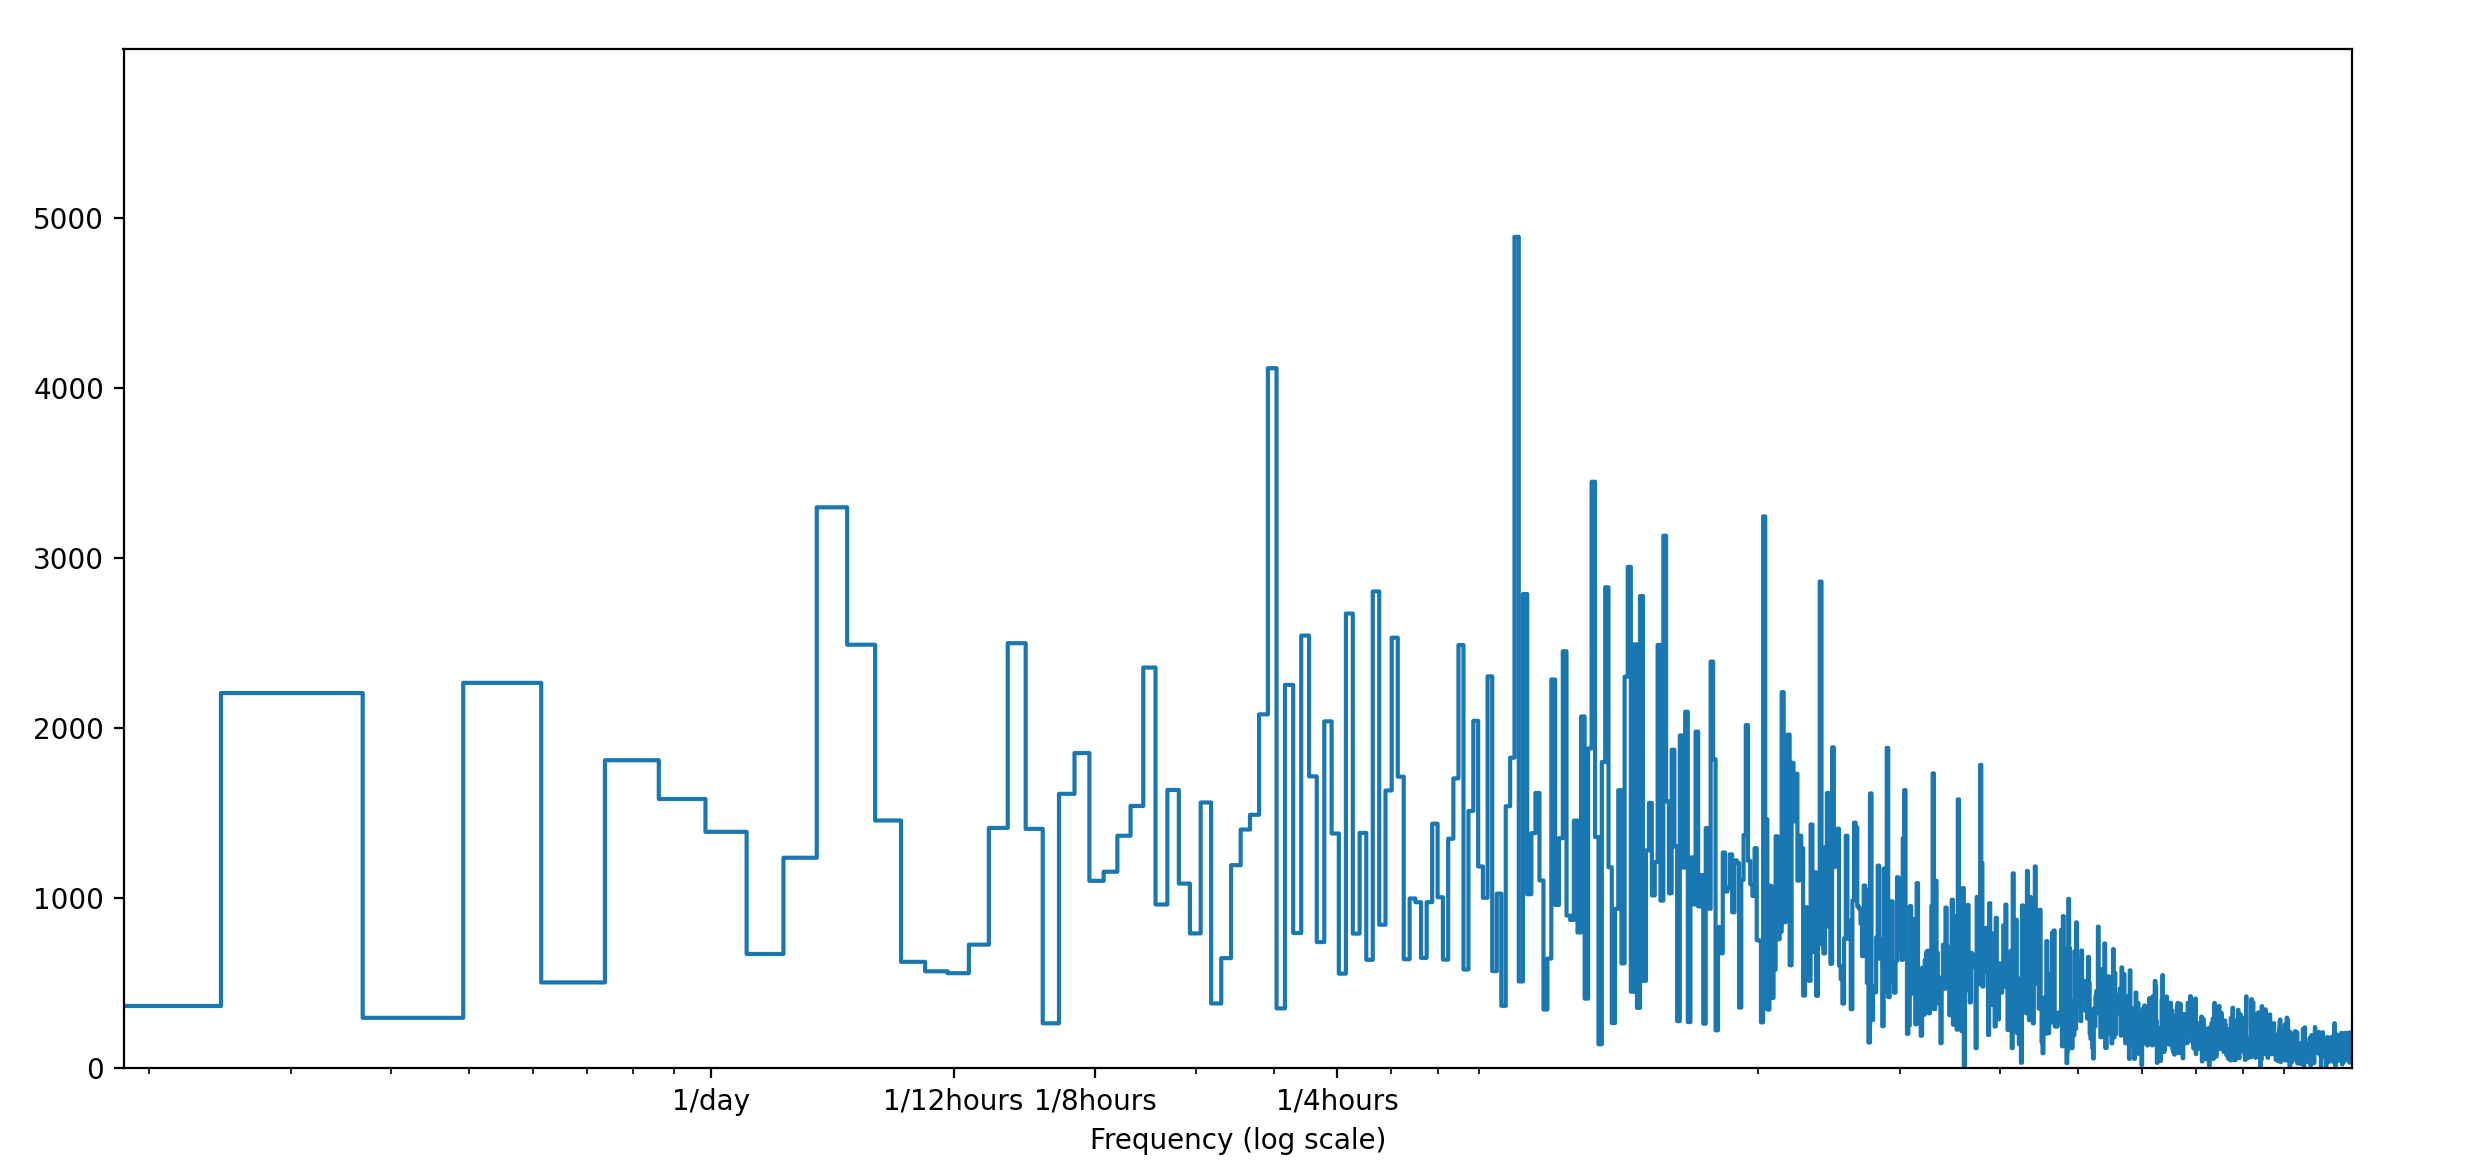

Clearly, there is no clear periodicity greater than 1 hour here. The hypothesis that there exists a periodicity every 8 hours does not hold true and therefore this feature is ommited from the experiment. 




# 3.0 Hyperparameter Selection

Hyperparameters are pre-set configurations critical to the structure and training strategy of deep learning models. Key examples include learning rate, batch size, epochs, and the number of layers in a neural network. Their adjustment, essential for maximizing model performance, involves systematic testing and validation. Upcoming sections will discuss methods for hyperparameter tuning and their impact on model efficacy.
 
# 3.1 Neural Network Size

The graph below shows the relationship between the number of LSTM (Long Short-Term Memory) units in a recurrent neural network (RNN) and the model's performance as measured by the validation Mean Absolute Error (MAE). It shows data for a model trained with 1000 epochs, a learning rate of 0.001, a sequence size of 12 and a batch size of 1024. The units are varied between lstm_units, rnn_units = [16, 32, 64, 128, 256, 512]. In the following code:

In [7]:
def lstm(self, lstm_units, rnn_units):
    multi_lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(lstm_units, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(rnn_units),
        tf.keras.layers.Dense(1)
    ])
    return multi_lstm_model

From the graph, we can observe the following that the validation MAE is lowest when the number of LSTM units is around 16, suggesting that this is the optimal number of units for this particular model configuration and dataset. As the number of LSTM units increases beyond 16, the validation MAE begins to rise, indicating a degradation in model performance. 

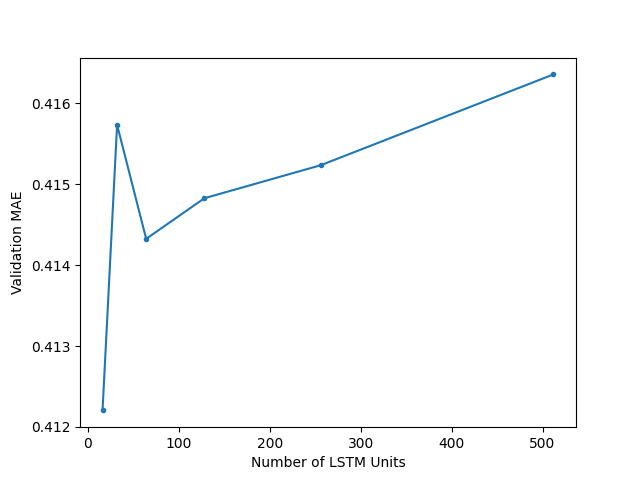


A larger network, indicated by an increased number of Long Short-Term Memory (LSTM) units, leading to a higher Mean Absolute Error (MAE) could be due to several factors:

1. Overfitting: A larger network has a higher capacity to learn from the data, which means it could start memorizing the training data rather than learning the underlying patterns. This is especially true if the training data is not diverse enough or if the model is trained for too many epochs without adequate regularization.

2. Vanishing/Exploding Gradients: In very deep networks or networks with many units, gradients can become very small (vanish) or very large (explode) during backpropagation, making it difficult for the model to learn effectively.

3. Batch Size: Although a batch size of 1024 is quite large, which is typically good for generalization, it might still be inappropriate for a larger network. The relationship between batch size and network size is not linear and finding the optimal batch size is part of hyperparameter tuning.

4. Complexity of the Model: A more complex model, which a larger LSTM network certainly is, may require a more sophisticated optimization strategy. The learning rate of 0.001 might be too small or too large for this larger model, impeding its ability to find a good solution.


As the difference in MAE is relatively small for different sizes of network, 16 units are chosen as it shows the lowest MAE and also means training time is less.

# 3.2 Learning Rate

The learning rate in machine learning is a critical hyperparameter that determines the size of the steps taken during the optimisation process. Specifically, the updating of model weights in response to the error in each iteration of the training. It directly impacts how quickly or slowly a model learns. A learning rate that's too high can cause the model to converge too quickly to a suboptimal solution at a local minimum, or it may even diverge, failing to find a solution. Conversely, a learning rate that's too low leads to a slow convergence process, increasing the computational cost and time required for training, and potentially getting stuck in local minima. The importance of the learning rate lies in its control over the model's ability to navigate the complex, high-dimensional landscape of a loss function. Striking the right balance in setting the learning rate is crucial for training effective models that can generalise well from training data to new data.


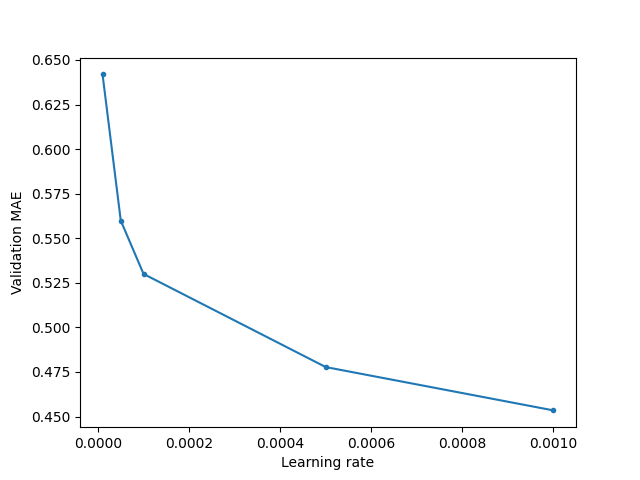


The graph above depicts the relationship between the learning rate and the validation Mean Absolute Error (MAE) for a recurrent neural network (RNN) with specific hyperparameters: 1000 epochs, LSTM with 16 units, RNN with 16 units, a sequence size of 12 and a batch size of 1024. 

From the graph, it's evident that there is an inverse relationship between the learning rate and the validation MAE for the recurrent neural network (RNN) configuration provided. A higher learning rate leading to a lower Mean Absolute Error (MAE) can initially seem counterintuitive because we often caution against setting the learning rate too high to avoid overshooting minima in the loss landscape. However, there are a few reasons why a higher learning rate might result in a lower MAE in certain contexts:

1. Underfitting at Low Learning Rates: If the learning rate is too low, the model may not sufficiently update its weights and biases to capture the underlying patterns in the data, leading to underfitting. A higher learning rate can provide the larger adjustments needed to the model parameters, allowing the model to better fit the training data.

2. Efficient Exploration: A somewhat higher learning rate can allow the model to explore the loss landscape more broadly and potentially escape local minima to find better (lower) points in terms of MAE.


A value of 0.001 is chosen for the learning rate for this model as it shows the least MAE while also meaning the model trains faster. 

# 3.3 Sequence history used to make prediction


Sequence size in recurrent neural networks (RNNs), refers to the amount of temporal input data the model considers to make a prediction. It's essentially the window of historical data that the model uses to understand and learn from sequences. This parameter is crucial because it determines the extent of temporal context available to the model; too little data and the model may miss important patterns, too much and the model may become overwhelmed by noise or irrelevant information, leading to overfitting. 

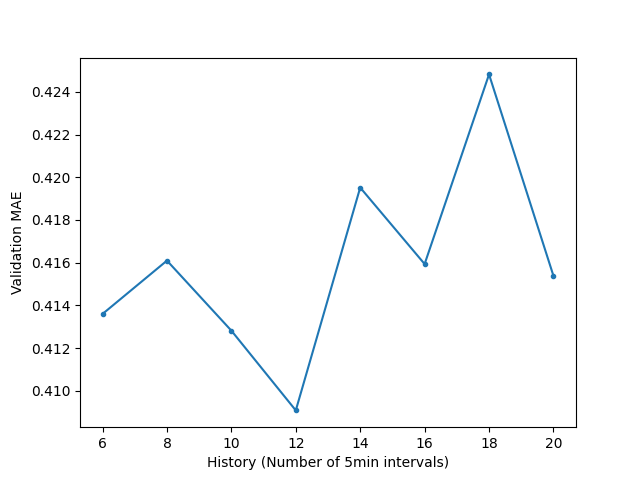

The graph above illustrates how the history size, measured in the number of 5-minute intervals, affects the validation Mean Absolute Error (MAE) for a recurrent neural network (RNN) with the specified parameters: 1000 epochs, LSTM with 16 units, RNN with 16 units, learning rate of 0.001 and a batch size of 1024. The graph shows a minimum value at 1 hour of history. This actually matches with anecdotal reporting that someone with Type 1 diabetes will look at the last hour of data to make a judgement on where their glucose levels are heading. As the history increases too far it is clear that the MAE goes away from this minimum. An explanation of this is that the model is using too much data over a longer period to give accurate predictions, and is overfitting. 

From this exploration, a sequence size of 12 is used throughout. 

# Results & Discussion





The batch size of the model was varied between batch_sizes = [128, 256, 512, 1024]. The models were tested using 


5: GRU, LSTM, RNN vs MAE
6: SGD vs Adam vs RNN vs Last value MAE
7: Future Prediction timesteps vs MAE
8: Graphs of 30min predictions 
9: Final MAE using best method

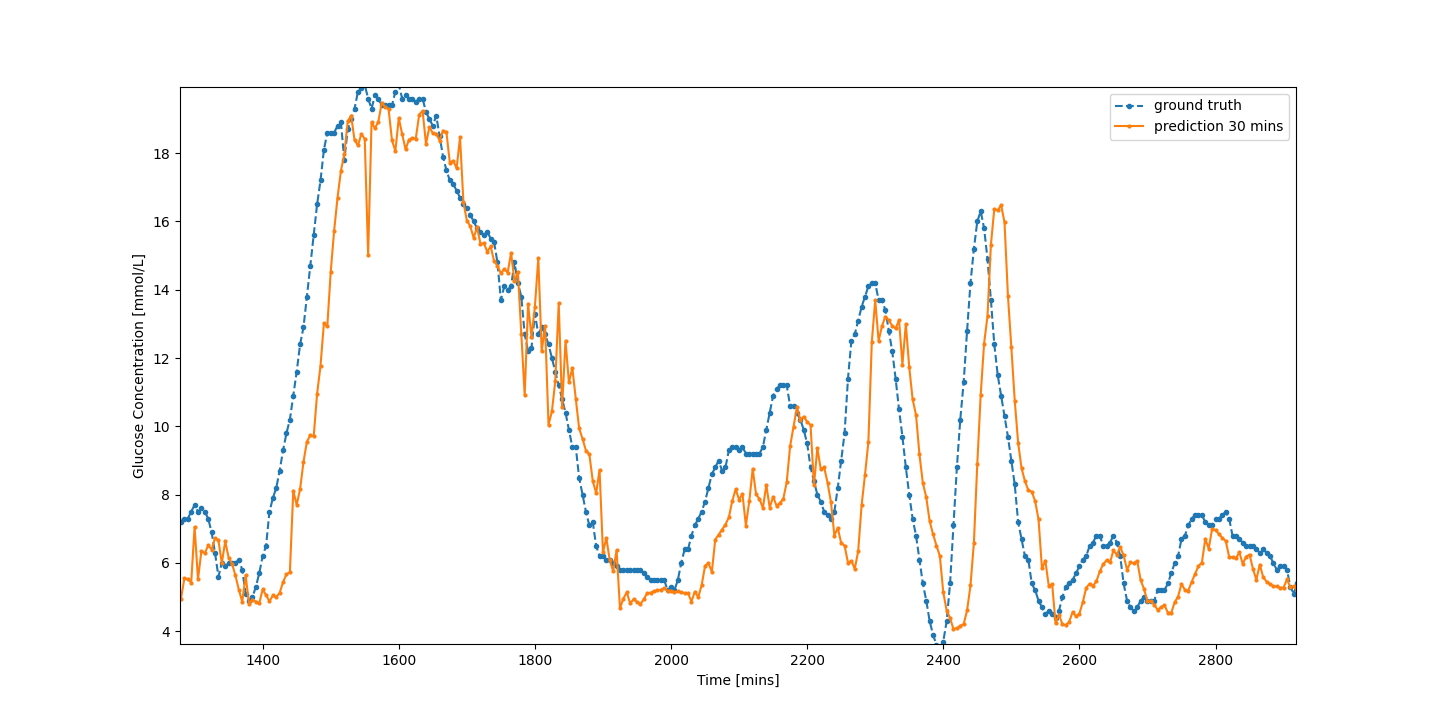